In [35]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [11]:
dataset = MNIST(root="data/",download=True, transform = ToTensor())

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

label: 5


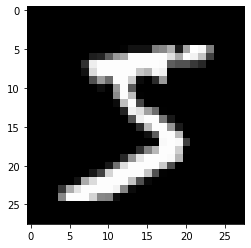

In [13]:
plt.imshow(dataset[0][0][0],cmap="gray")
print(f"label: {dataset[0][1]}")

In [14]:
n = len(dataset)
val_pct = 0.2
def split_indices(n, val_pct):
    n_val = int(val_pct * n)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

In [15]:
train_indices, val_indices = split_indices(n, val_pct)

In [72]:
batch_size = 100

train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, batch_size, sampler=train_sampler)

valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset, batch_size, sampler=valid_sampler)

## Model

In [26]:
for xb, yb in train_dl:
    xb = xb.view(xb.size(0), -1)
    print(xb.shape)
    print(xb)
    break

torch.Size([100, 784])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [36]:
class MnistModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_size)
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out

In [37]:
input_size = 784
num_classes = 10
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [38]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [39]:
for images, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print(f"Loss: {loss.item()}")
    break

torch.Size([100, 1, 28, 28])
Loss: 2.3014726638793945


In [40]:
torch.cuda.is_available()

True

In [41]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [42]:
device = get_default_device()
device

device(type='cuda')

In [43]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [44]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])
cuda:0


In [73]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [74]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [78]:
for xb, yb in valid_dl:
    print(xb.device)
    print(yb)
    break

cuda:0
tensor([1, 7, 3, 3, 7, 4, 0, 4, 5, 8, 6, 5, 4, 6, 3, 2, 4, 3, 7, 2, 9, 1, 3, 2,
        4, 8, 4, 9, 0, 3, 0, 2, 7, 7, 3, 1, 5, 7, 0, 5, 5, 6, 7, 4, 0, 8, 4, 6,
        9, 0, 8, 4, 9, 2, 2, 6, 3, 5, 4, 1, 7, 3, 1, 4, 7, 1, 5, 4, 1, 8, 3, 4,
        1, 6, 8, 3, 4, 3, 5, 1, 9, 7, 1, 4, 9, 2, 9, 0, 9, 7, 8, 8, 8, 2, 0, 0,
        4, 3, 8, 8], device='cuda:0')


## Training

In [59]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    preds = model(xb)
    loss = loss_func(preds, yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)
    return loss.item(), len(xb), metric_result

In [60]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        losses, nums, metrics = zip(*results)
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

In [76]:
valid_dl

In [61]:
def fit(epochs, lr, model, loss_fn, train_dl, valid_dl, metric=None, opt_fn = None):
    losses, metrics = [], []
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        for xb, yb in train_dl:
            loss_batch(model, loss_fn, xb, yb, opt)
        val_loss, total, val_metric = evaluate(model, loss_fn, valid_dl, metric)
        
        losses.append(val_loss)
        metrics.append(val_metric)
        
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'
                  .format(epoch+1, epochs, val_loss, 
                          metric.__name__, val_metric))
    return losses, metrics

In [87]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [79]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [88]:
val_loss, total, val_acc = evaluate(model, F.cross_entropy, valid_dl, metric=accuracy)
print(f"Loss: {val_loss} Accuracy: {val_acc}")

Loss: 2.308397457997004 Accuracy: 0.09616666666666666


In [89]:
losses1, metrics1 = fit(5, 0.5, model, F.cross_entropy, train_dl, valid_dl, accuracy)

Epoch [1/5], Loss: 0.2430, accuracy: 0.9275
Epoch [2/5], Loss: 0.1766, accuracy: 0.9458
Epoch [3/5], Loss: 0.1498, accuracy: 0.9557
Epoch [4/5], Loss: 0.1399, accuracy: 0.9582
Epoch [5/5], Loss: 0.1356, accuracy: 0.9584
